C:\Users\rewas\AppData\Local\Temp\ipykernel_17156\1715621193.py:23: RuntimeWarning: overflow encountered in long_scalars
  return l_0**2*fiber_length*D_l/(4*np.pi*c)*(omega-omega_mean)**2


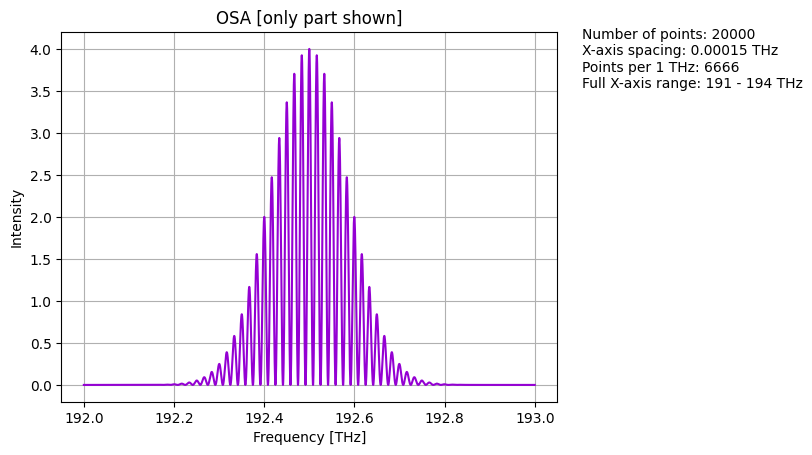

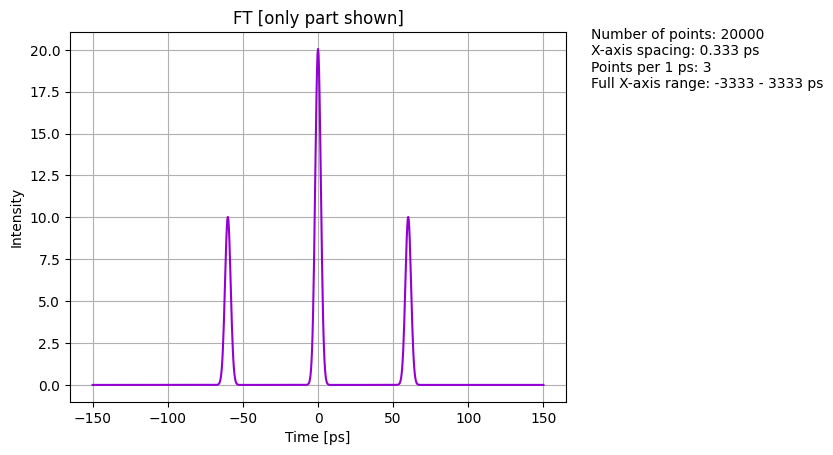

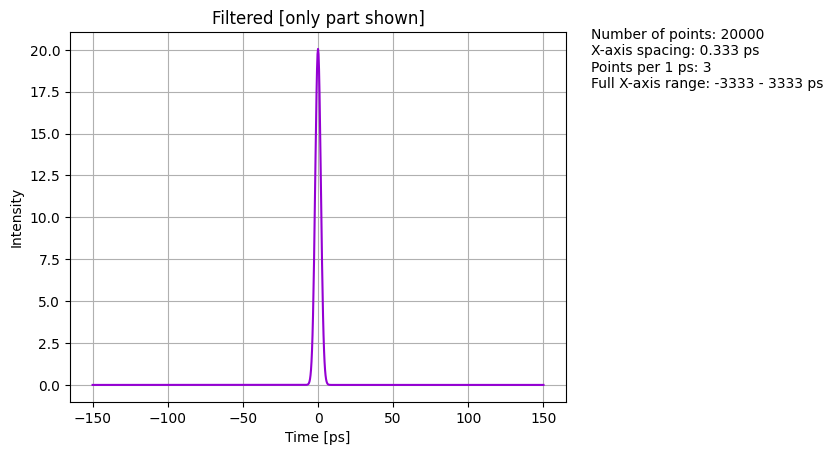

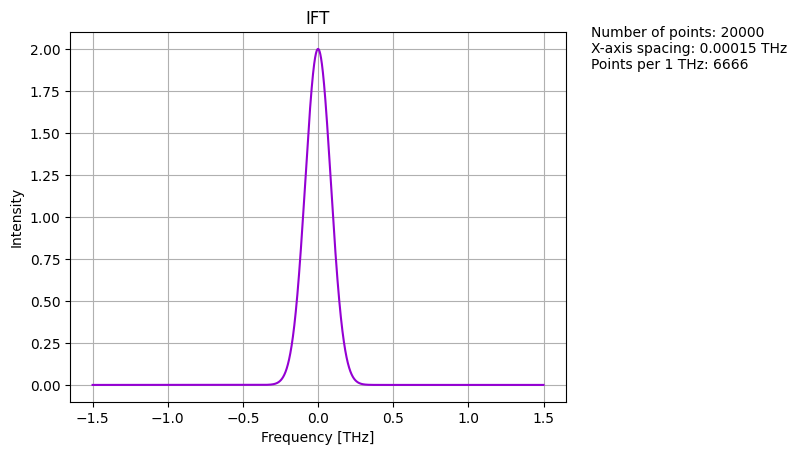

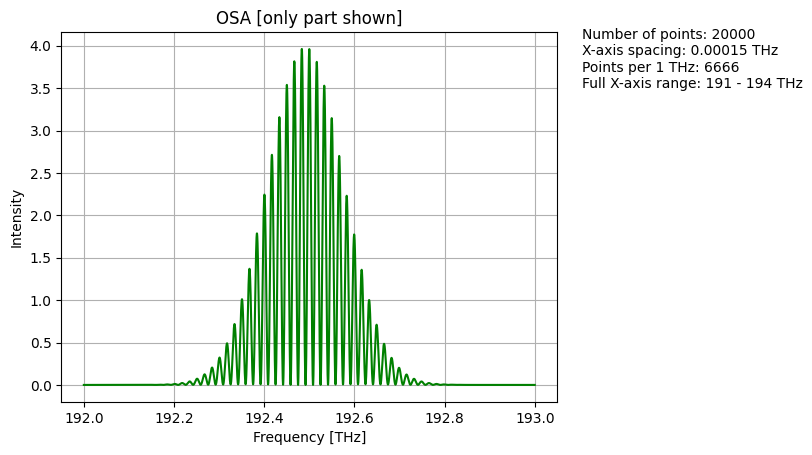

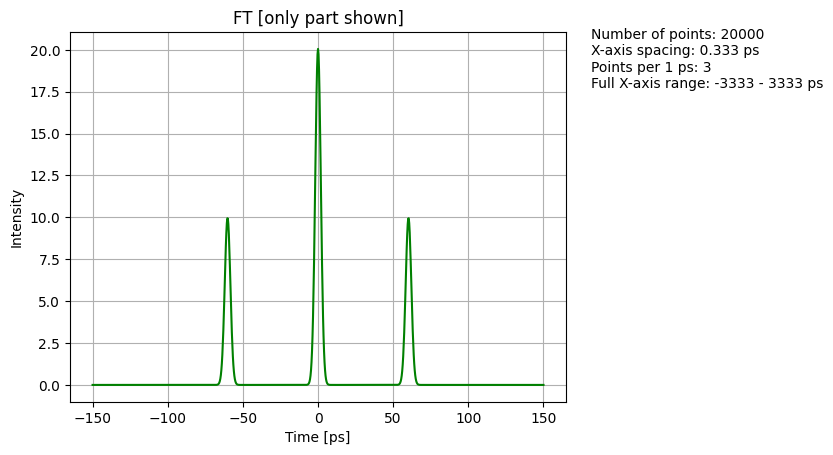

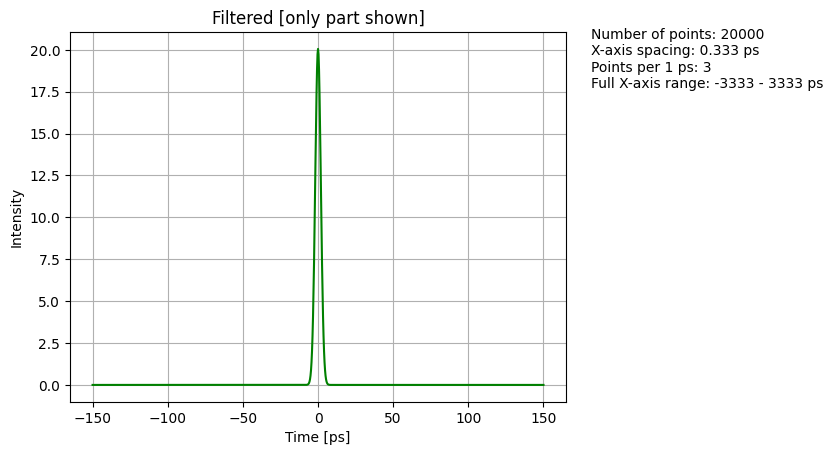

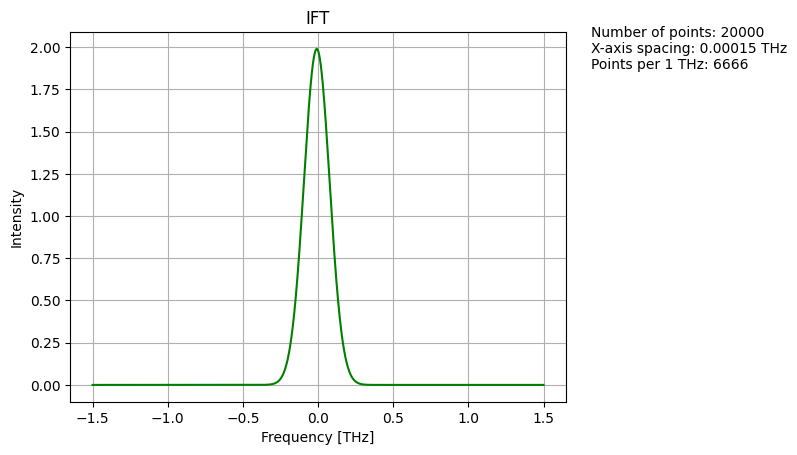

In [24]:
import numpy as np
import pandas as pd
import spectral_analysis as sa
from spectral_analysis import spectrum, ray
import matplotlib.pyplot as plt

import importlib
import sys
module = sys.modules["spectral_analysis"]
importlib.reload(module)

# prepare the pulse

def gaussian(omega, mu, sig):
    return np.exp(-np.power(omega - mu, 2.) / (2 * np.power(sig, 2.)))

def phase(f, f_mean, fiber_length):
    l_0 = 1560
    c = 3*1e8
    D_l = 17
    omega = f*2*np.pi
    omega_mean = f_mean*2*np.pi
    return l_0**2*fiber_length*D_l/(4*np.pi*c)*(omega-omega_mean)**2

gaussian = np.vectorize(gaussian)
phase = np.vectorize(phase)
colors = ["darkviolet", "green"]

for i in range(2):

    X = np.linspace(191,194,20000)
    Y = gaussian(X, 192.5, 0.12)*np.exp(1j*phase(X, 192.5, 80))

    Y = Y.astype(complex)
    X = X.astype(complex)

    # prepare first pulse
    spectre = sa.spectrum(X, Y, "freq", "intensity")

    # prepare sheared and delayed pulse
    
    if i == 0:
        spectre_shifted = spectre.copy()
    else:
        spectre_shifted = spectre.very_smart_shift(0.017, inplace = False)   # shearing

    spectre_shifted.Y*=np.exp(2j*np.pi*60*spectre_shifted.X)                # delaying

    spectre.Y += spectre_shifted.Y   # mix them 1:1
    spectre.Y *=np.conjugate(spectre.Y)    # that we get from OSA

    if i == 0:
        not_sheared_spectrum = spectre.copy()
    else:
        sheared_spectrum = spectre.copy()


    # and that's enough for SPIDER


    sa.plot(spectre.copy(), start = 192, end = 193, title = "OSA", color = colors[i])

    # fourier
    spectre.fourier()
    sa.plot(spectre, start = -150, end = 150, title = "FT", color = colors[i])

    # filtering DC
    spectre.replace_with_zeros(start = None, end = -30)
    spectre.replace_with_zeros(start = 30, end = None)
    sa.plot(spectre, start = -150, end = 150, title = "Filtered", color = colors[i])

    # inverse fourier
    spectre.inv_fourier()

    if i == 0:
        spectre1 = spectre.copy()
    else:
        spectre2 = spectre.copy()
    sa.plot(spectre, title = "IFT", color = colors[i])

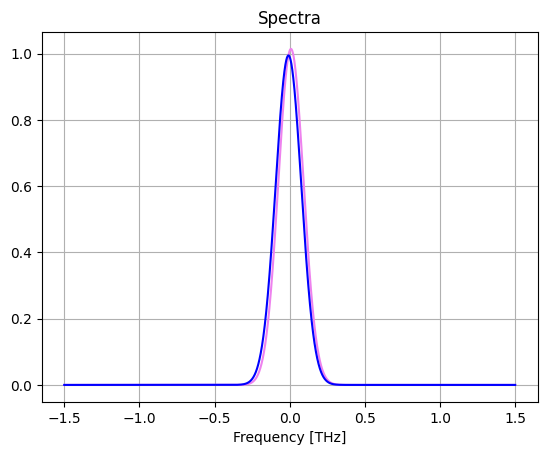

0.016800840042002104


In [25]:
spectre2.Y /= 2
spectre1.Y -= spectre2.Y
sa.compare_plots([spectre1, spectre2])
print(sa.find_shift(spectre1, spectre2))

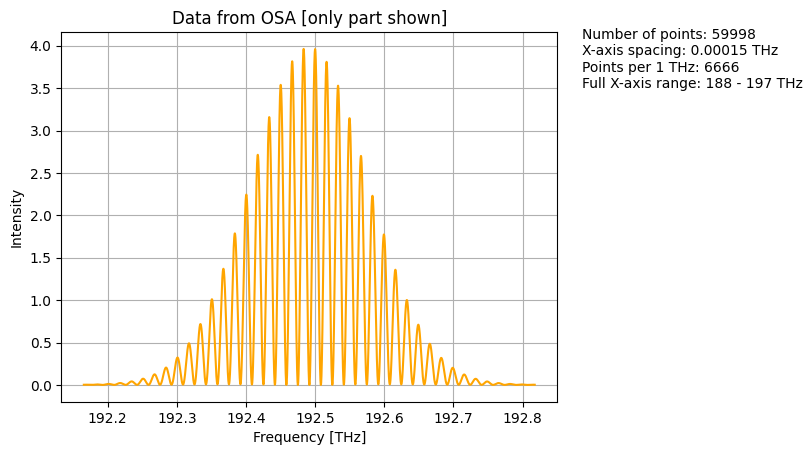

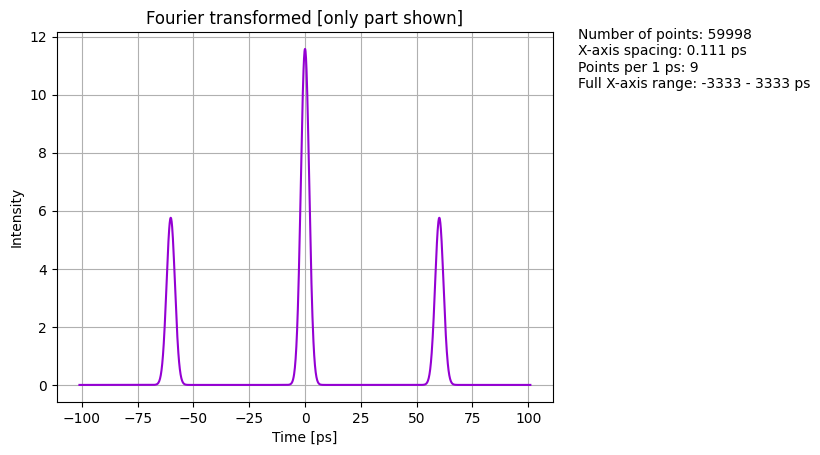

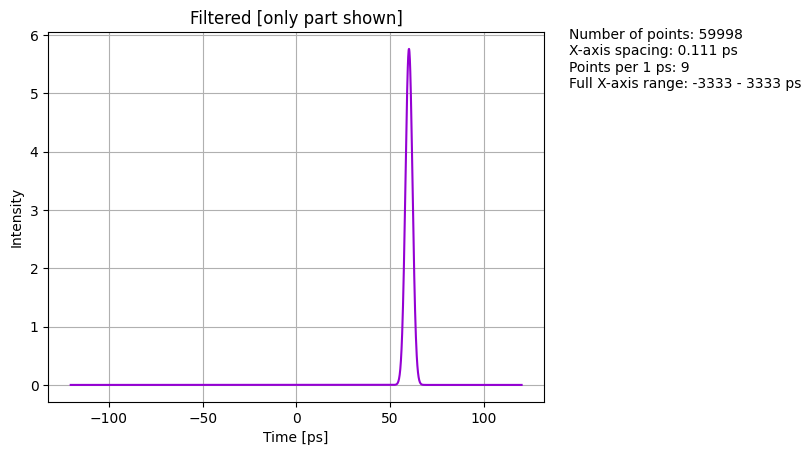

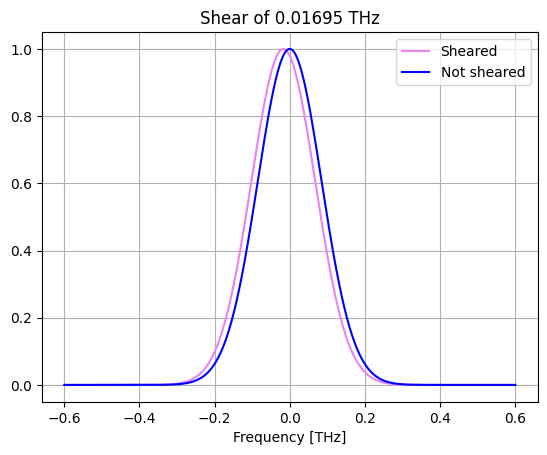

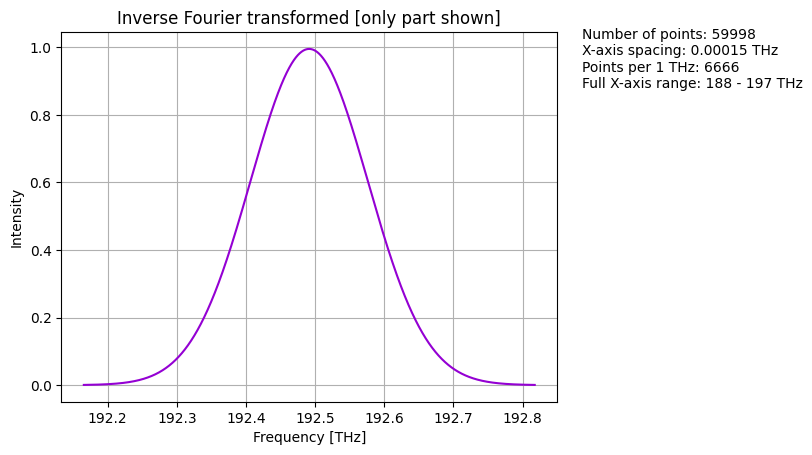

d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


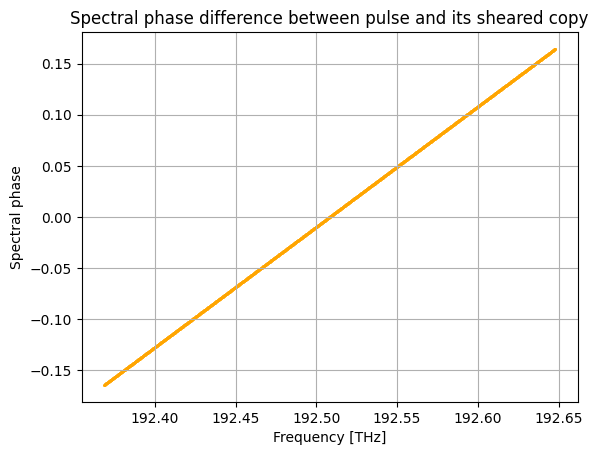

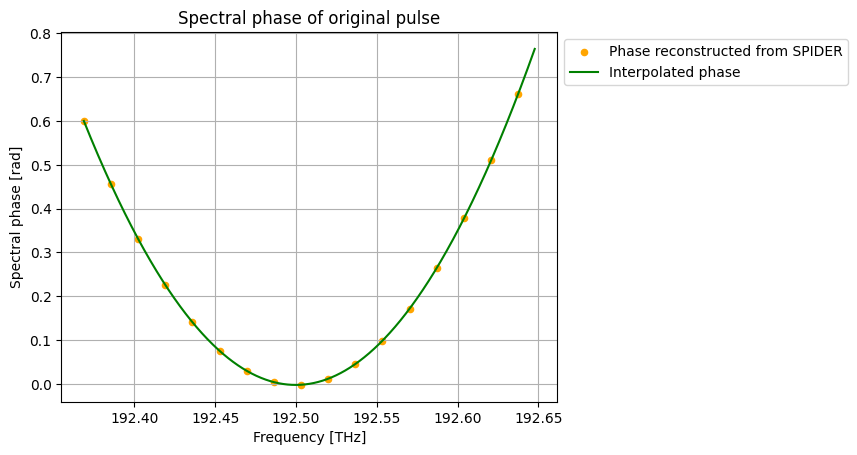

In [26]:
sa.spider(phase_spectrum = sheared_spectrum,
          temporal_spectrum = not_sheared_spectrum,
          plot_steps = True,
          plot_phase = True,
          plot_shear = True)